In [183]:
# Step 1: Import Libraries and Load Dataset
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, SMOTENC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

# Load dataset
data = pd.read_csv("loan_data.csv")


In [160]:
# Step 2: Data Preprocessing
# Check for missing values
# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# 1.1 Handle missing values for numerical columns
print('Missing data for numerical field:',numerical_cols.isnull().sum())
data[numerical_cols] = data[numerical_cols].apply(lambda col: col.fillna(col.median()))

# 1.2 Handle missing values for categorical columns
print('Missing data for categorical field:',categorical_cols.isnull().sum())
data[categorical_cols] = data[categorical_cols].apply(lambda col: col.fillna(col.mode()[0]))

# 2.1 Remove outliers in numerical columns using the IQR method
target = 'LoanApproved'
for col in numerical_cols:
    if (col != target):
        #print (col)
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
            
            # Filter out outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# 2.2 Handle rare categories in categorical columns by grouping them into an "Other" category
for col in categorical_cols:
    if (col != target):
        freq_counts = data[col].value_counts(normalize=True)
        rare_categories = freq_counts[freq_counts < 0.01].index  # Categories with < 1% frequency
        data[col] = data[col].apply(lambda x: 'Other' if x in rare_categories else x)

# 3.1 Handle Imbalanced Classes for numerical field
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Define features and target
X = data.drop('LoanApproved', axis=1)  # Replace 'fraudulent' with the actual target column
y = data['LoanApproved']

X_numerical = data[numerical_cols]
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle imbalanced classes in the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# 3.2 Handle Imbalanced Classes for categorical field
# Split the combined data into training and testing sets
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify indices of categorical columns for SMOTENC
categorical_indices = [X.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTENC to the combined data
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_resampled_comb, y_resampled_comb = smote_nc.fit_resample(X_train_comb, y_train_comb)


Missing data for numerical field: 0
Missing data for categorical field: 0


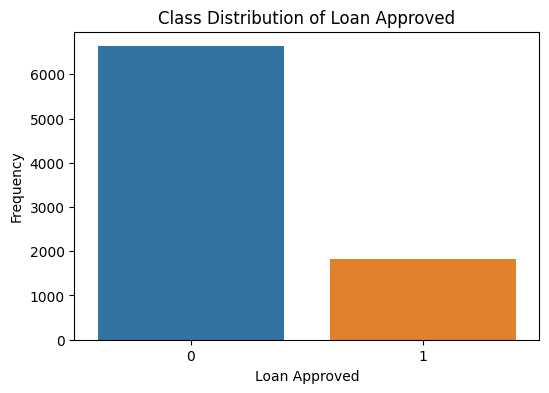

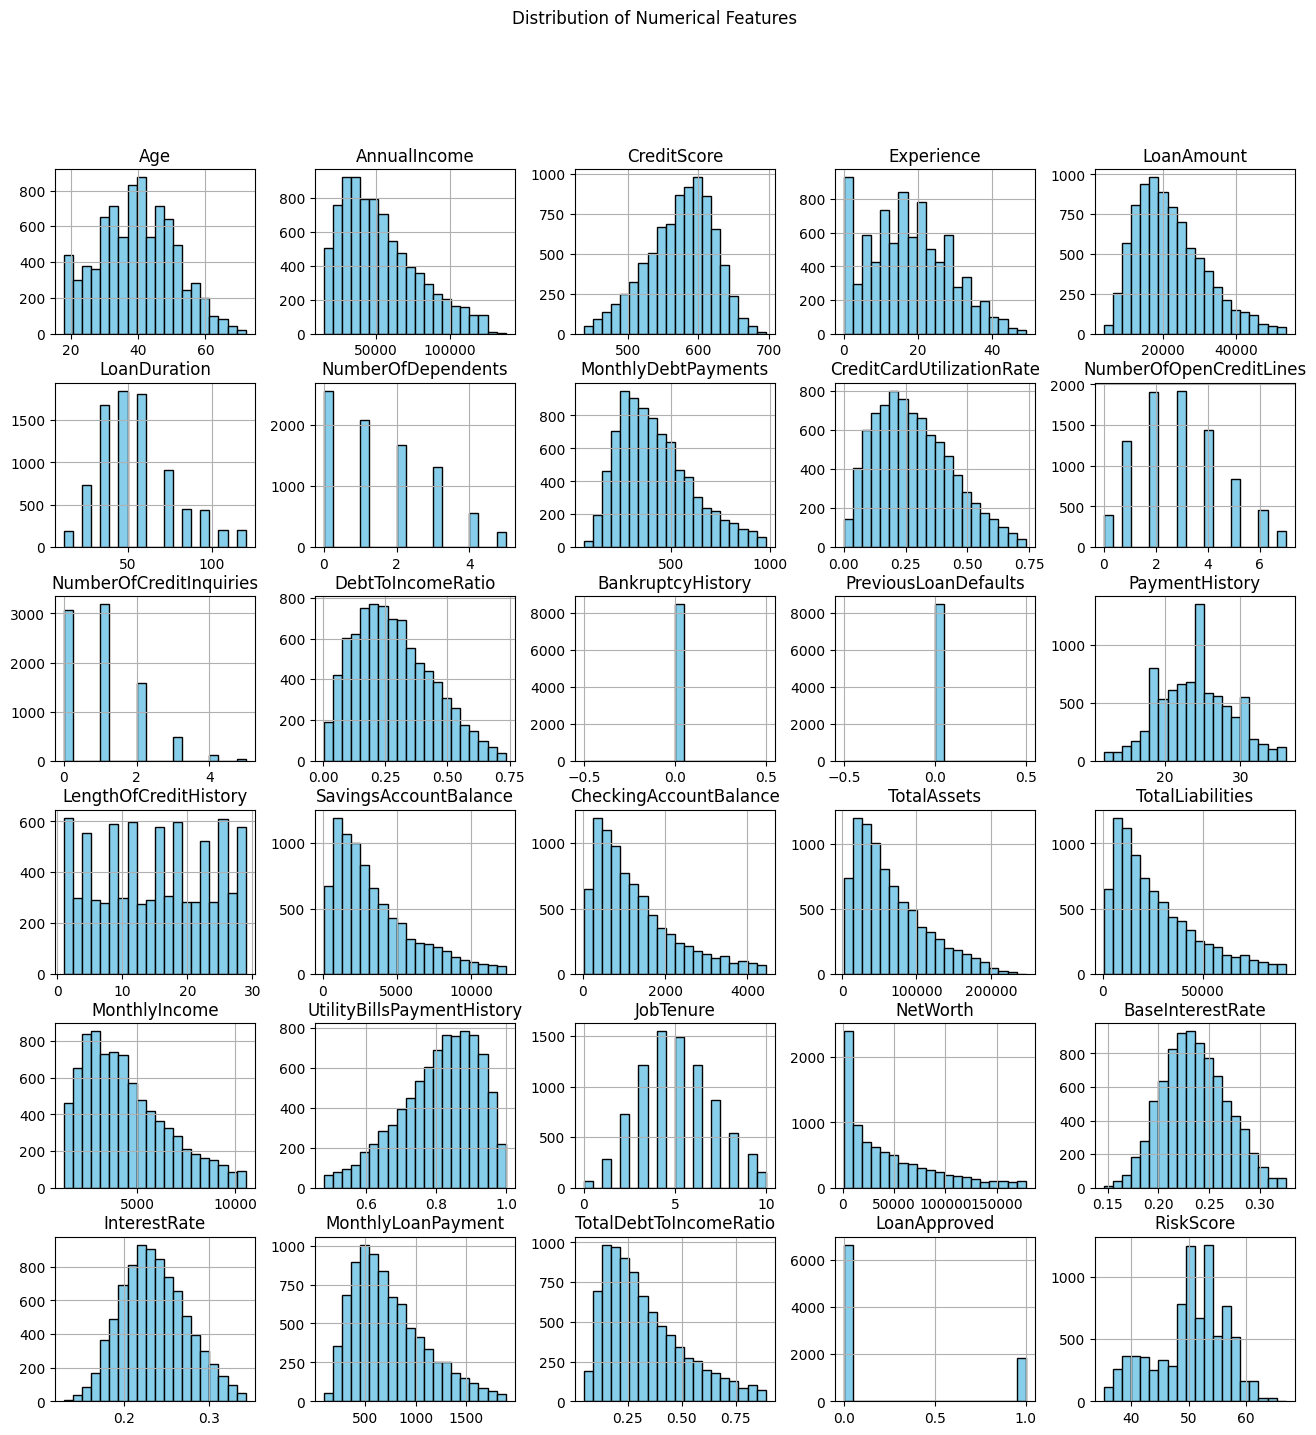

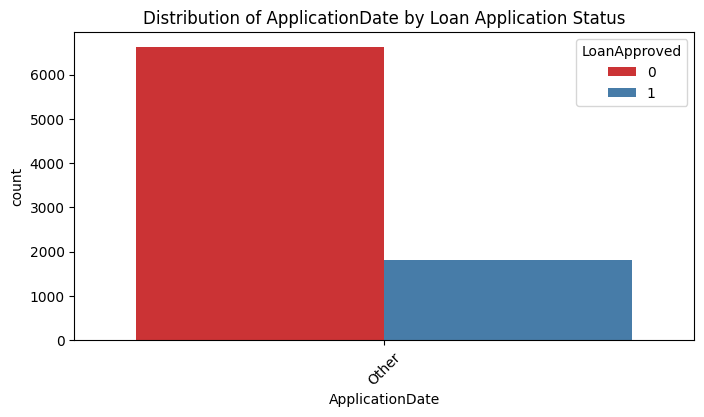

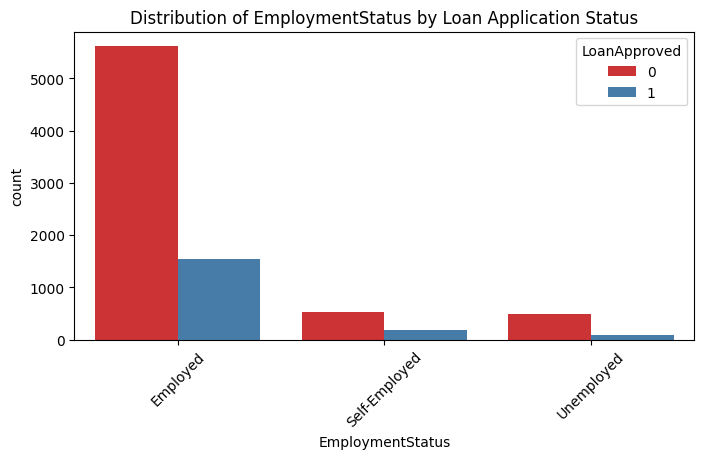

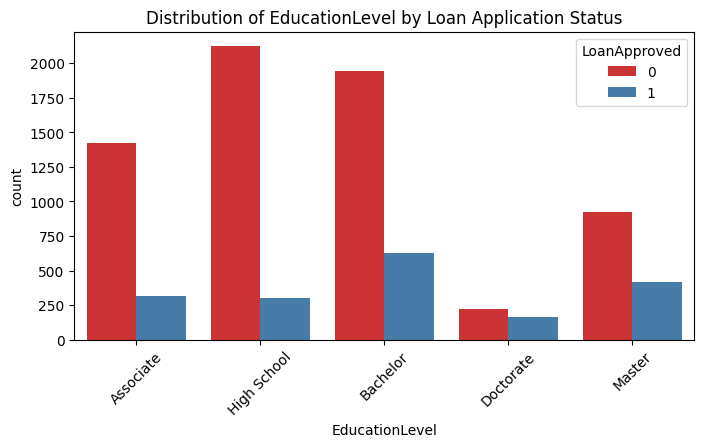

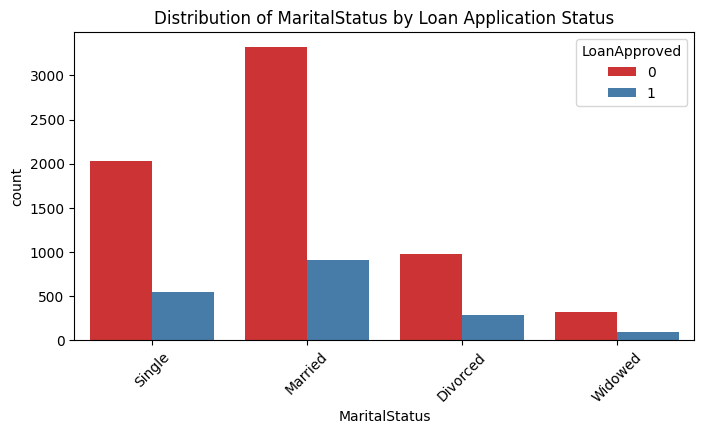

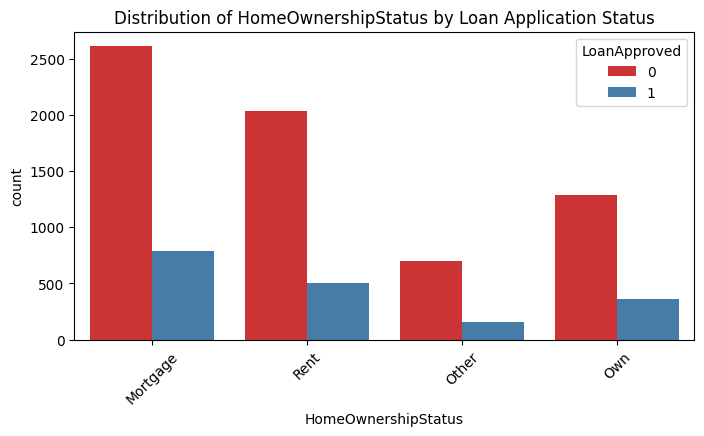

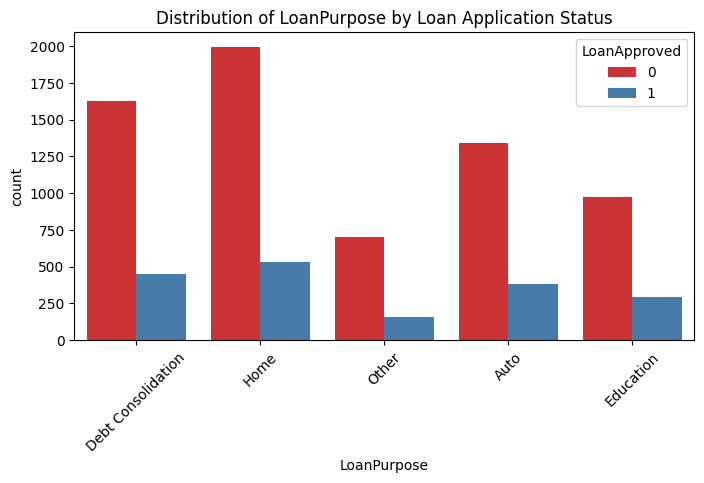

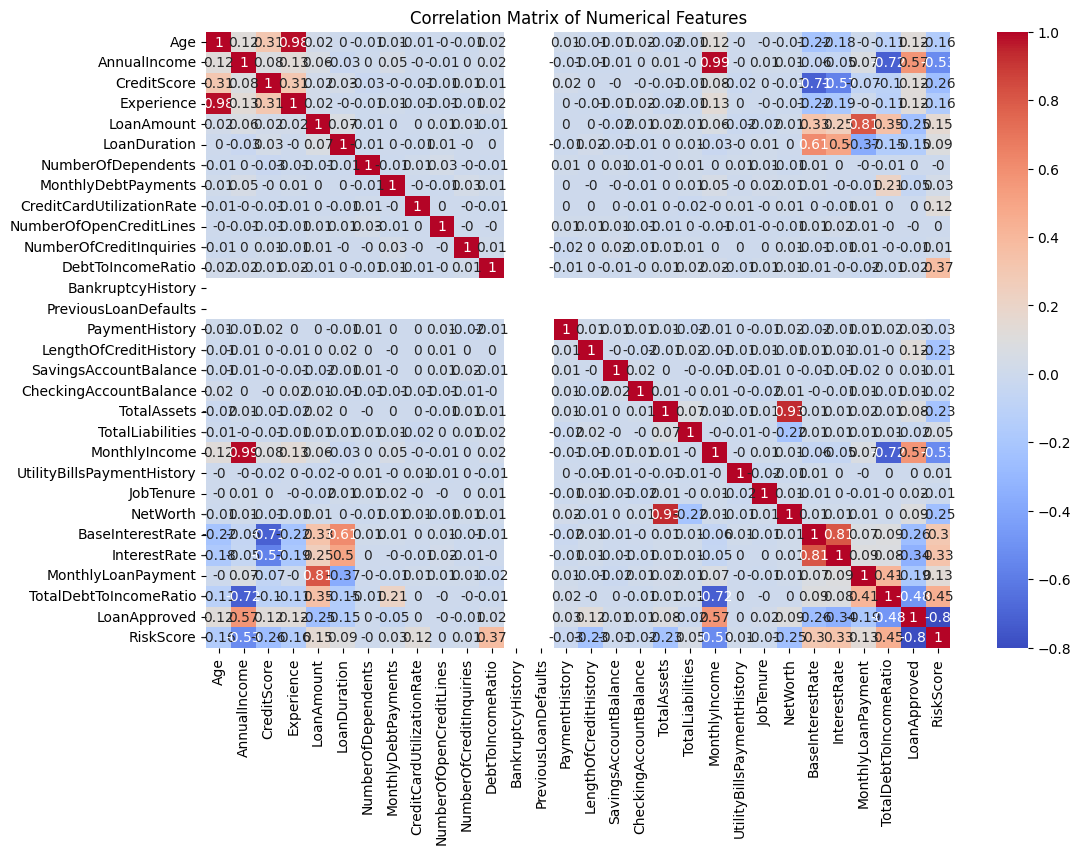

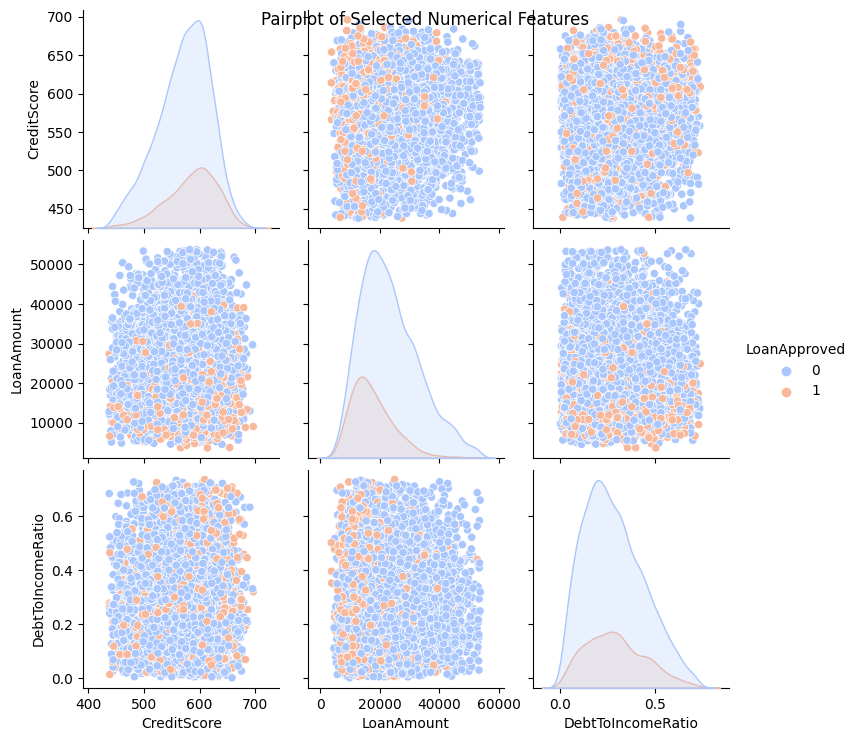

In [161]:
# Step 3: Exploratory Data Analysis (EDA)
# Plotting the distribution of the target variable
# 1. Class Distribution of Target Variable (Loan Approved)
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='LoanApproved')
plt.title('Class Distribution of Loan Approved')
plt.xlabel('Loan Approved')
plt.ylabel('Frequency')
plt.show()

# 2. Distribution of Numerical Features
data[numerical_cols].hist(bins=20, figsize=(16, 16), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

# 3. Distribution of Categorical Features
# Bar plots for each categorical feature
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=data, x=col, hue=target, palette="Set1")
    plt.title(f"Distribution of {col} by Loan Application Status")
    plt.xticks(rotation=45)
    plt.show()

# 4. Correlation Matrix for Numerical Features (with 3 decimal points)
# Compute the correlation matrix and round to 3 decimal points
correlation_matrix = data[numerical_cols].corr().round(2)
# Plotting the heatmap with 2 decimal places
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# 5. Pairplot for Selected Highly Correlated Numerical Features with Target
# Selecting a few features that might be highly correlated with Loan Approved for pairplot
selected_features = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'LoanApproved']
sns.pairplot(data[selected_features], hue='LoanApproved', palette='coolwarm')
plt.suptitle("Pairplot of Selected Numerical Features")
plt.show()


In [163]:
# Step 4: Feature Engineering

# 1. Income per Dependent to highlight financial burden
data['Income_per_Dependent'] = data['AnnualIncome'] / (data['NumberOfDependents'] + 1)

# 2. Loan-to-Asset Ratio - high loan-to-asset ratio might indicate increased fraud risk
if 'TotalAssets' in data.columns:
    data['Loan_to_Asset_Ratio'] = data['LoanAmount'] / (data['TotalAssets'] + 1e-5)

# 3. High Loan Amount Flag to set a certain threshold
data['High_Loan_Amount'] = (data['LoanAmount'] > data['LoanAmount'].mean()).astype(int)

# 4. Family Size 
# Update 'MaritalStatus' column based on the mapping
if 'MaritalStatus' in data.columns:
    #print (data['MaritalStatus'])
    if data['MaritalStatus'].dtype == 'object': 
        data['MaritalStatus'] = data['MaritalStatus'].map({'Married': 1, 'Single': 0, 'Widowed': 0, 'Divorced': 0})
        #print (data['MaritalStatus'])
    
# Calculate Family Size (assuming Married is now a binary column: 1 if married, 0 otherwise)
if 'MaritalStatus' in data.columns and 'NumberOfDependents' in data.columns:
    data['Family_Size'] = data['MaritalStatus'] + data['NumberOfDependents']

# Prepare data for model training
# Separate features and target variable
target_column = 'LoanApproved'  
X = data.drop(columns=[target_column])
y = data[target_column]

# Convert categorical features to numerical
X = pd.get_dummies(X, drop_first=True)
#print (X)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a model to evaluate feature impact (using a basic Random Forest model)
modelrf = RandomForestClassifier(random_state=42)
modelrf.fit(X_train, y_train)

# Predictions
y_pred = modelrf.predict(X_test)

# Evaluate model performance
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Performance with New Features")

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Feature Importance Analysis
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n", feature_importances)

Model Performance with New Features
Precision: 0.98
Recall: 0.97
F1 Score: 0.98
Confusion Matrix: 
[[2014   12]
 [  13  496]]

Feature Importances:
                            Feature  Importance
29                       RiskScore    0.459683
28          TotalDebtToIncomeRatio    0.104820
21                   MonthlyIncome    0.077782
1                     AnnualIncome    0.076960
26                    InterestRate    0.054286
30            Income_per_Dependent    0.021988
4                       LoanAmount    0.020634
25                BaseInterestRate    0.016999
27              MonthlyLoanPayment    0.014947
31             Loan_to_Asset_Ratio    0.013597
5                     LoanDuration    0.011673
16           LengthOfCreditHistory    0.010674
12               DebtToIncomeRatio    0.009637
2                      CreditScore    0.008861
24                        NetWorth    0.008093
19                     TotalAssets    0.007271
32                High_Loan_Amount    0.006583
8    

In [164]:
# Step 5: Model Building
# Model building using XGBoost 
# Calculate scale_pos_weight for XGBoost based on class imbalance
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance for XGBoost
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Calculate scale_pos_weight for XGBoost based on class imbalance
positive_class = y_train_smote.sum()  # Number of positive class instances
negative_class = len(y_train_smote) - positive_class  # Number of negative class instances
scale_pos_weight = negative_class / positive_class

# Train the XGBoost model with scale_pos_weight
model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
model_xgb.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate the model
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Cross-validation on training data
cv_scores = cross_val_score(model_xgb, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f}")


Precision: 0.99
Recall: 1.00
F1 Score: 1.00
Confusion Matrix: 
[[2023    3]
 [   0  509]]
Cross-validation accuracy: 1.00


In [165]:
# Model buidling using LightGBM 
# Apply class weights to handle class imbalance for LightGBM
model_lgb = lgb.LGBMClassifier(class_weight='balanced',verbose=-1,random_state=42)  # Automatically handles imbalance
#model_lgb = lgb.LGBMClassifier(random_state=42)

# Fit the model
model_lgb.fit(X_train_smote, y_train_smote)

# Predict on test data
y_pred_lgb = model_lgb.predict(X_test)

# Calculate Precision, Recall, F1-Score, and Confusion Matrix
precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
conf_matrix = confusion_matrix(y_test, y_pred_lgb)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Cross-validation on training data
cv_scores = cross_val_score(model_lgb, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.2f}")

Precision: 0.99
Recall: 0.99
F1 Score: 0.99
Confusion Matrix: 
[[2020    6]
 [   3  506]]
Cross-validation accuracy: 1.00


In [166]:
# Random Forest with hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Set up parameter grid for cross-validation
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters and model evaluation
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Results:")
print("Best Parameters:", grid_search_rf.best_params_)
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Precision: 0.9686888454011742
Recall: 0.9724950884086444
F1 Score: 0.9705882352941176
Confusion Matrix:
 [[2010   16]
 [  14  495]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2026
           1       0.97      0.97      0.97       509

    accuracy                           0.99      2535
   macro avg       0.98      0.98      0.98      2535
weighted avg       0.99      0.99      0.99      2535



In [170]:
# XGBoost with hyperparameter tuning
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Set up parameter grid for cross-validation

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model evaluation
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Results:")
print("Best Parameters:", grid_search_xgb.best_params_)
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[2026    0]
 [   0  509]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2026
           1       1.00      1.00      1.00       509

    accuracy                           1.00      2535
   macro avg       1.00      1.00      1.00      2535
weighted avg       1.00      1.00      1.00      2535



In [171]:
# LightGBM with hyperparameter tuning

import warnings
warnings.filterwarnings("ignore")  # This will ignore all warnings

from lightgbm import LGBMClassifier

# Initialize LightGBM with verbose parameter set to -1
lgbm_model = LGBMClassifier(verbose=-1)

#lgbm_model = LGBMClassifier(random_state=42)

# Set up parameter grid for cross-validation
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation
grid_search_lgbm = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Best parameters and model evaluation
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)

print("LightGBM Results:")
print("Best Parameters:", grid_search_lgbm.best_params_)
print("Precision:", precision_score(y_test, y_pred_lgbm))
print("Recall:", recall_score(y_test, y_pred_lgbm))
print("F1 Score:", f1_score(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print(classification_report(y_test, y_pred_lgbm))


LightGBM Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
 [[2026    0]
 [   0  509]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2026
           1       1.00      1.00      1.00       509

    accuracy                           1.00      2535
   macro avg       1.00      1.00      1.00      2535
weighted avg       1.00      1.00      1.00      2535



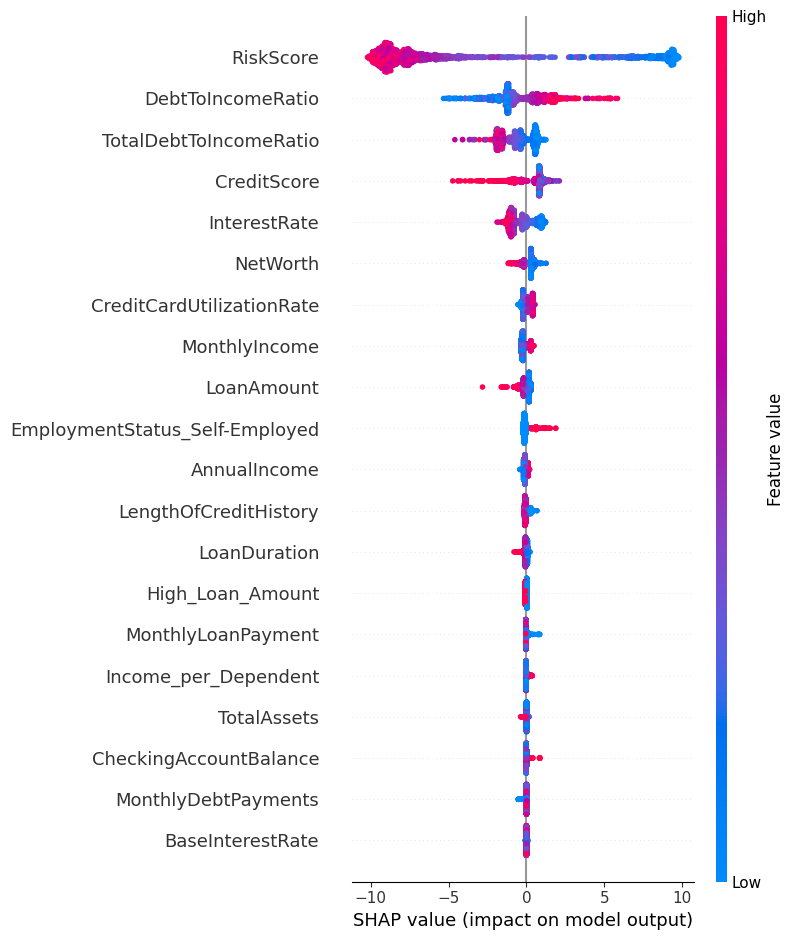

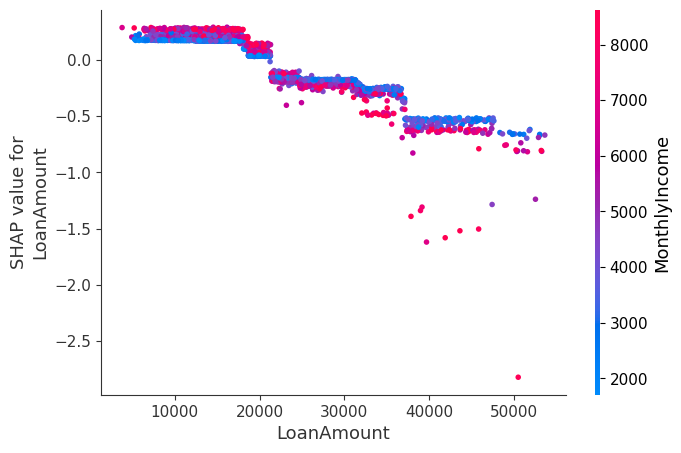

                           feature  importance
29                       RiskScore    7.840252
12               DebtToIncomeRatio    1.324137
28          TotalDebtToIncomeRatio    0.997594
2                      CreditScore    0.878274
26                    InterestRate    0.773093
24                        NetWorth    0.353979
9        CreditCardUtilizationRate    0.261748
21                   MonthlyIncome    0.240744
4                       LoanAmount    0.223545
34  EmploymentStatus_Self-Employed    0.164777


In [172]:
# Step 6: Model Interpretability:
# Create the SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(model_xgb)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Dependence plot for a specific feature, e.g., "LoanAmount"
shap.dependence_plot("LoanAmount", shap_values, X_test)


# Create a DataFrame to store feature importance
shap_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values(by="importance", ascending=False)
print(shap_importance.head(10))  # Display top 10 most important features


Misclassified samples:
        Age  AnnualIncome  CreditScore  Experience  LoanAmount  LoanDuration  \
13437   50         65644          575          32       18367            24   
18399   50         28515          530          29        5894            48   
18316   52         76396          594          26       19445            36   
4100    21         59802          604           0       13757            96   
13854   38         90883          650          14       25548           108   

       MaritalStatus  NumberOfDependents  MonthlyDebtPayments  \
13437              0                   4                  247   
18399              1                   4                  200   
18316              1                   4                  768   
4100               0                   4                  269   
13854              1                   0                  247   

       CreditCardUtilizationRate  ...  HomeOwnershipStatus_Other  \
13437                   0.639274  ...     

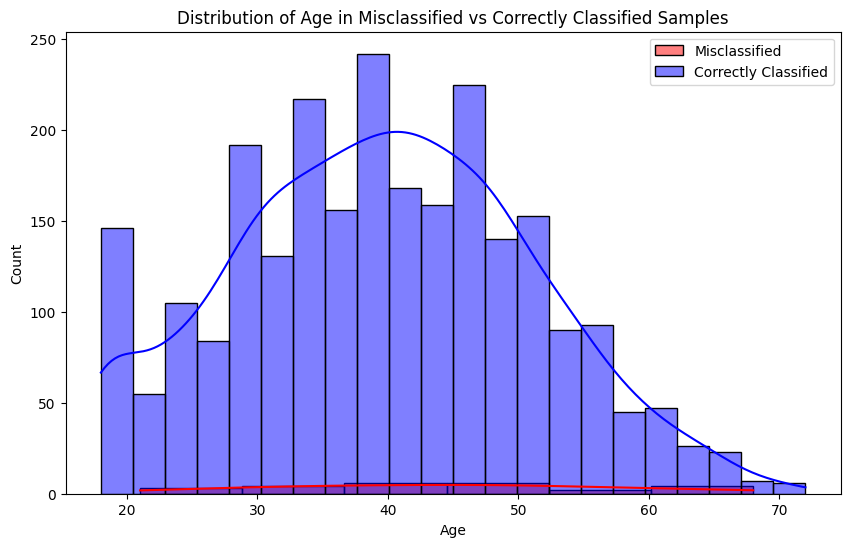

In [178]:
# Step 7: Model Performance and Error Analysis
# Predict probabilities for both classes
modelrf = RandomForestClassifier(random_state=42)
modelrf.fit(X_train, y_train)

y_pred_probs = modelrf.predict_proba(X_test)[:, 1]
y_pred = modelrf.predict(X_test)

# Create a DataFrame to analyze errors
error_analysis_df = X_test.copy()
error_analysis_df['Actual'] = y_test
error_analysis_df['Predicted'] = y_pred
error_analysis_df['Pred_Prob'] = y_pred_probs

# Identify Misclassified Instances
# Filter to find misclassified samples
misclassified_df = error_analysis_df[error_analysis_df['Actual'] != error_analysis_df['Predicted']]
print("Misclassified samples:\n", misclassified_df.head())

# Error Pattern Analysis
# 1. Confidence of Predictions:
# Find misclassifications with low confidence (e.g., probability close to 0.5)
uncertain_misclassified = misclassified_df[(misclassified_df['Pred_Prob'] > 0.4) & (misclassified_df['Pred_Prob'] < 0.6)]
print("Low Confidence Misclassifications:\n", uncertain_misclassified)

# 2. Feature Analysis in Misclassifications:

# Example: Analyze a specific feature in misclassified vs correctly classified samples
feature = 'Age'  # Example feature
plt.figure(figsize=(10, 6))
sns.histplot(misclassified_df[feature], color='red', label='Misclassified', kde=True)
sns.histplot(error_analysis_df[error_analysis_df['Actual'] == error_analysis_df['Predicted']][feature], color='blue', label='Correctly Classified', kde=True)
plt.legend()
plt.title(f"Distribution of {feature} in Misclassified vs Correctly Classified Samples")
plt.show()



In [180]:
# Cross-Validation and Threshold Adjustment


from sklearn.metrics import precision_recall_curve

# Adjusting the threshold based on precision-recall trade-offs
y_pred_probs = modelrf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Select a threshold to balance precision and recall (e.g., maximizing F1 score)
optimal_threshold = thresholds[(precision + recall).argmax()]
print("Optimal Threshold:", optimal_threshold)

# Apply the threshold to adjust predictions
y_pred_adjusted = (y_pred_probs >= optimal_threshold).astype(int)
print("Adjusted F1 Score:", f1_score(y_test, y_pred_adjusted))


Optimal Threshold: 0.51
Adjusted F1 Score: 0.975417895771878
